# K-means Assignment

In [40]:
# Maths
import numpy as np
import pandas as pd
import scipy

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sqlalchemy import create_engine

# Ignore Warn
import warnings
warnings.filterwarnings('ignore')

1. Get the silhouette coefficient of the two cluster k-means solution. You'll notice that the silhouette coefficient will turn out to be greater than the one above where cluster number is three. We know that the Iris dataset consists of three different clusters. How do you explain that the silhouette score of the solution with the number of clusters being equal to the correct number of classes is lower than the one where the number of clusters is different from the correct number of classes?

In [2]:
# Getting the data
iris = datasets.load_iris()
X = iris.data
Y= iris.target

# Standardizing
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# K Means
labels = KMeans(n_clusters=2).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.5817500491982808


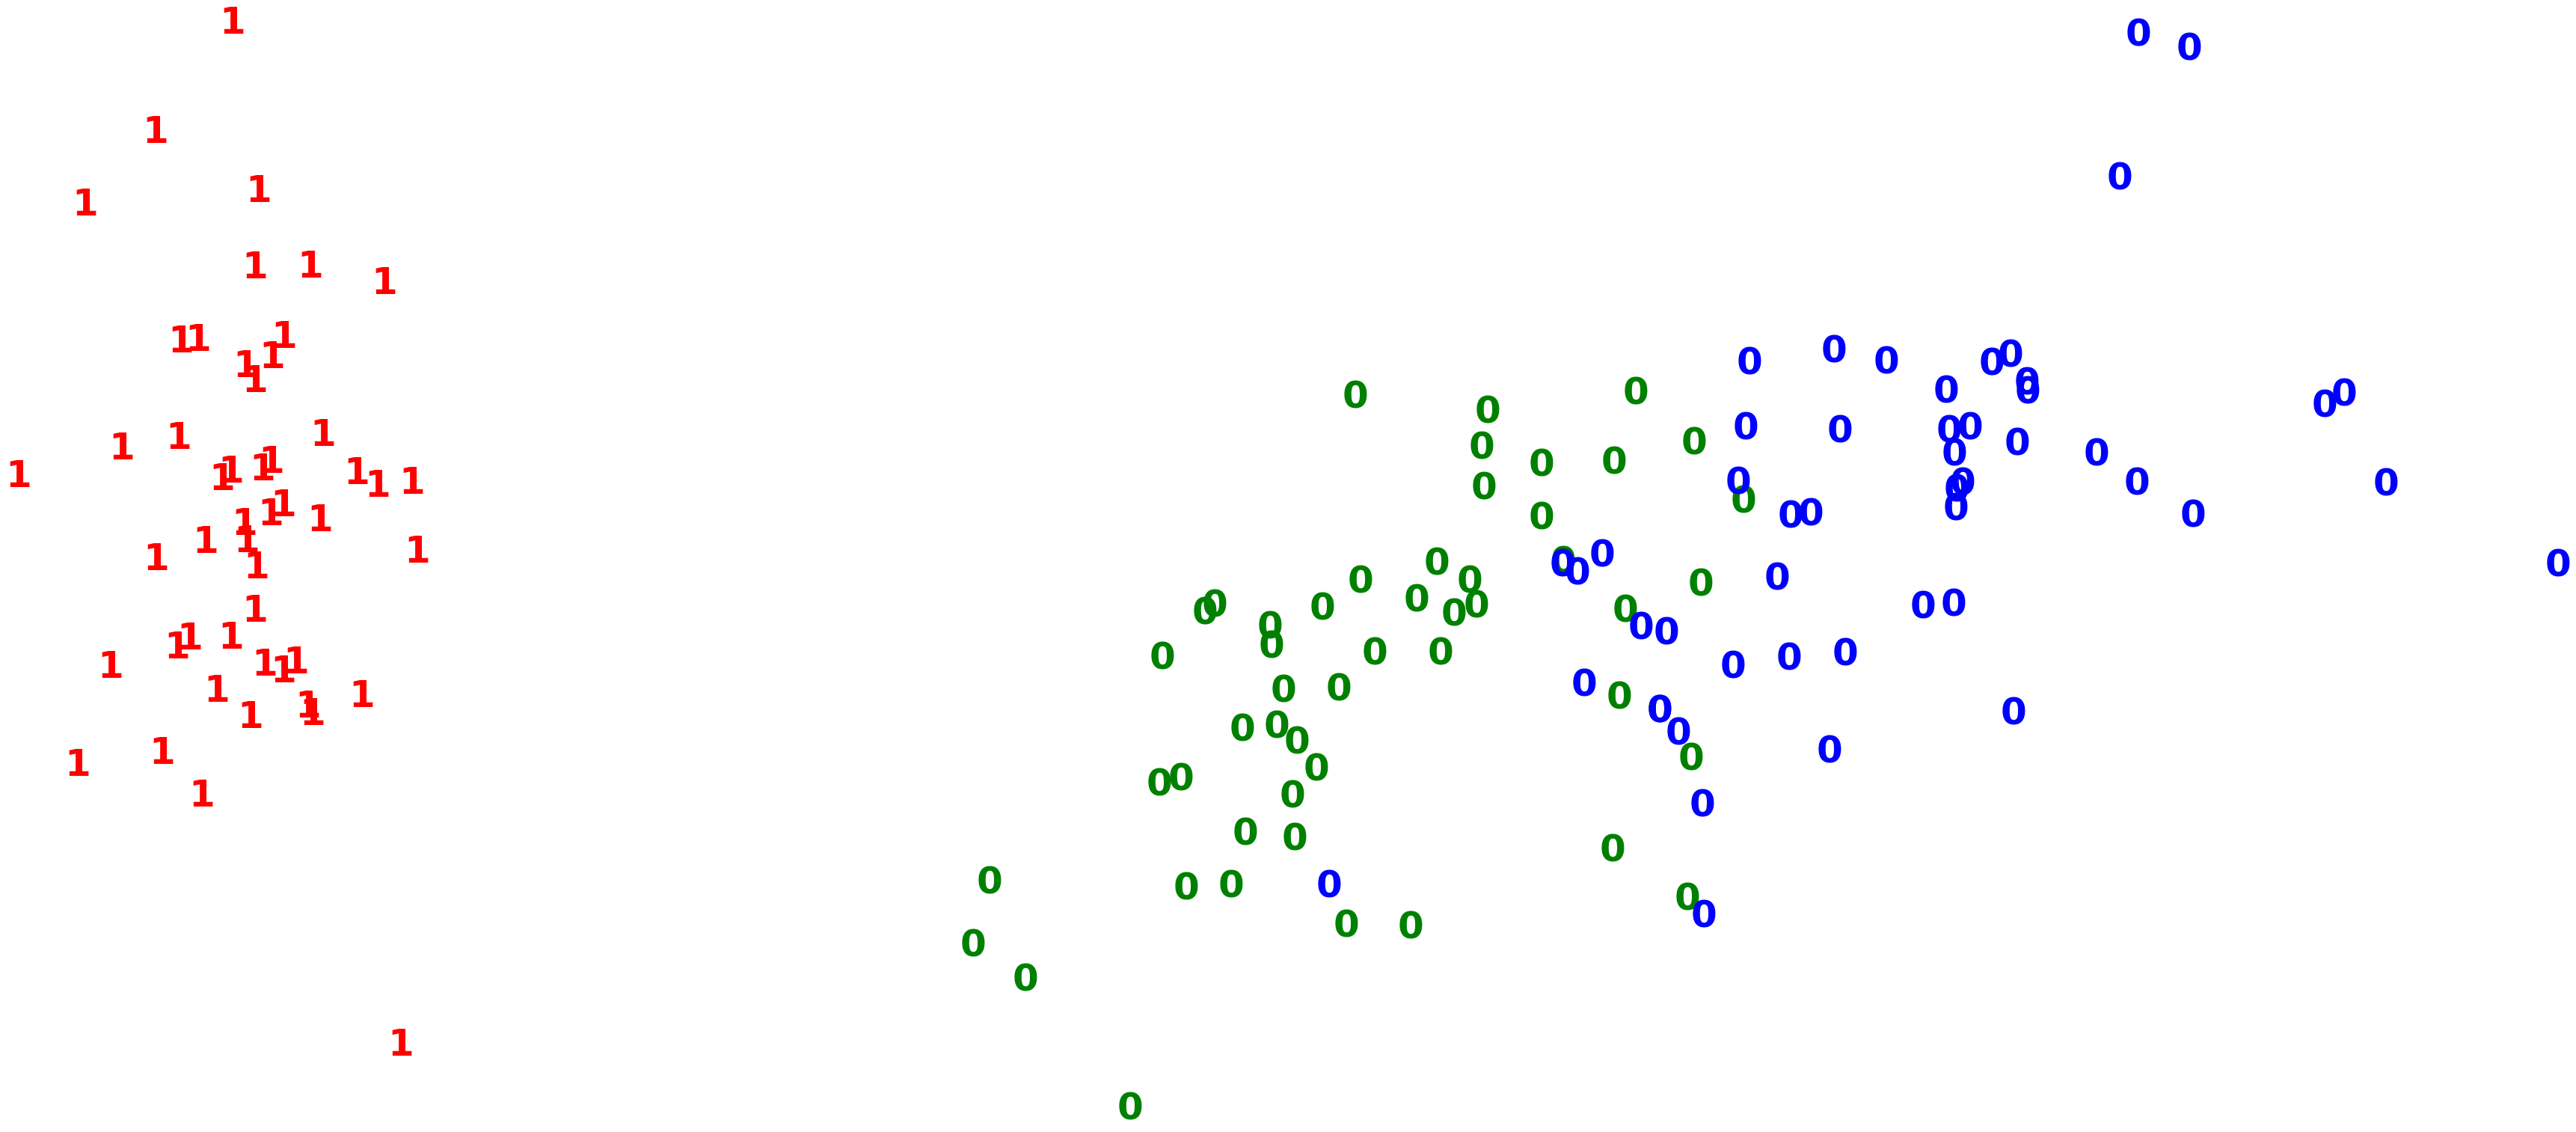

In [3]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colors = ['red', 'green', 'blue']
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(labels[i]),
             color=colors[Y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

The above plot is K-means = 2 with the overlay of the ground truth groups by color.
Because of the way the silhouette score is calcuated (comparison of the mean distance of points in own group vs mean distance from points of the nearest group), we will have better results with K=2 since the green and blue groups are so close together. Making the alg see only two groups will improve the score.

___
2. In this assignment, you'll be working with the heart disease dataset from the UC Irvine Machine Learning Repository.

    * Split the data randomly into two and apply k-means using two, three and four as the number of clusters as we did in our discussion of the consistency in this checkpoint. Assess the consistency of the solutions using visualization. Which one does seem to be the best one?
    * Apply k-means on the whole dataset by setting k is equal two, three and four and get ARI score for each of them. Which model is the best?
    *  Apply k-means on the whole dataset by setting k is equal two, three and four and get silhouette coefficient for each of them. Which model is the best?

In [93]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from heartdisease',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [94]:
# Define the features and the outcome
X = df.iloc[:-1, :13]
y = df.iloc[:-1, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y > 0, 0, 1)

In [95]:
# Standardizing
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into equally sized samples to show consistency across subsamples
X_half1, X_half2, X_PCAhalf1, X_PCAhalf2 = train_test_split(X_std, X_pca, test_size=0.5, random_state=222)

In [96]:
# Apply K-means and test different Ks
# Create a df to store values
ypred = pd.DataFrame()

In [97]:
# Passing a list of tuples which are the data used by k-means and the PCA used for plotting
# and employing a counter for the loop, then storing the predictions and PCA in the df
for counter, data in enumerate([
    (X_half1, X_PCAhalf1),
    (X_half2, X_PCAhalf2)]):
    
    # Putting features into ypred
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:,0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:,1]
    
    # Generate cluster predictions
    for nclust in range(2,5):
        pred = KMeans(n_clusters=nclust, random_state=222).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

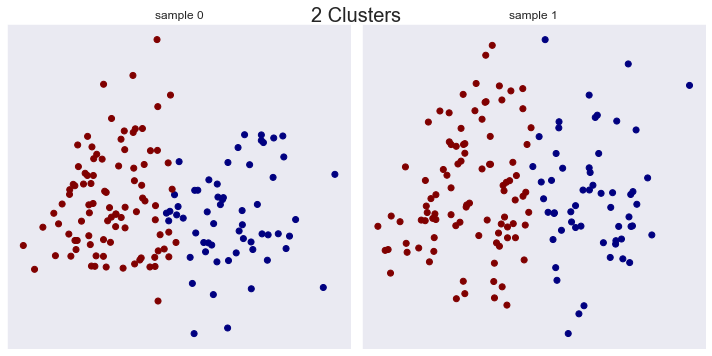

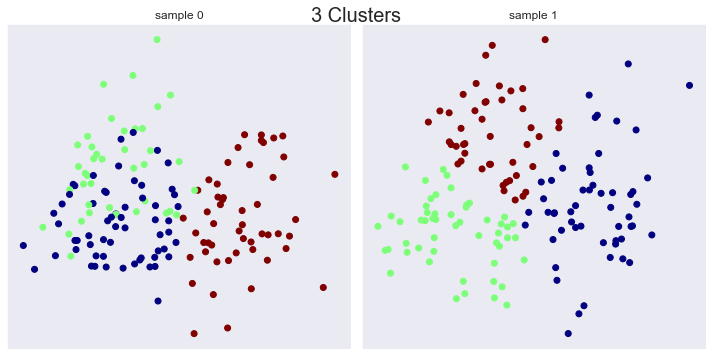

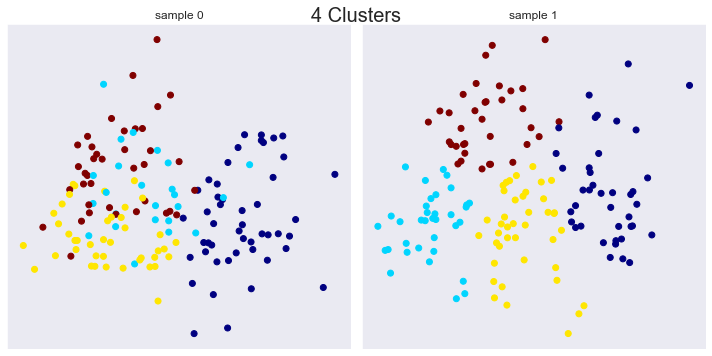

In [98]:
# Plotting clusters for each # of clusters using PCA
sns.set_style('dark')

for cluster in range(2,5):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    
    # plot for each sample
    for i in range(2):
        x_sub = ypred[f'pca_f1_sample{i}']
        y_sub = ypred[f'pca_f2_sample{i}']
    
        #cluster assignments
        c = ypred[f'clust{cluster}_sample{i}']
    
        # Assign subplot to grid
        ax[i].scatter(x_sub, y_sub, c=c, cmap='jet')
        ax[i].set_title(f'sample {i}')
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    plt.suptitle(f'{cluster} Clusters', fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

As we would guess, since we know the target is binary, the two-cluster version seems to separate the best.

In [92]:
for cluster in range(2,5):
    results = KMeans(n_clusters=cluster).fit_predict(X_std)
    silhouette = metrics.silhouette_score(X_std,results, metric='euclidean')
    ARI = metrics.adjusted_rand_score(y,results)
    print(('_'*30) + f'\nK-mean Clusters: {cluster}\n')
    print(f'Silhouette Score: {silhouette}')
    print(f'ARI Score: {ARI}')

______________________________
K-mean Clusters: 2

Silhouette Score: 0.17440650461256255
ARI Score: 0.43661540614807665
______________________________
K-mean Clusters: 3

Silhouette Score: 0.1288490357266075
ARI Score: 0.2761688306176955
______________________________
K-mean Clusters: 4

Silhouette Score: 0.13150417947451118
ARI Score: 0.2076727935243063


To confirm what we saw in the visual, 2 clusters seem to be the best solution. The Silhouette score is not great for any of the clusters. This is due to the fact that the clusters are very close and not dense. ARI tells us the model just better than random selection, but still not great.